In [2]:
me(%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
from math import sqrt
from pathlib import Path

import pandas as pd
from loguru import logger
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

from matplotlib import pyplot as plt

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
data_path = Path.cwd() / "data" / "r2.csv"
df = pd.read_csv(data_path)
y_col = "quality"
x_cols = [col for col in df.columns if col not in [y_col, "id"]]

<Axes: title={'center': 'Wine Quality Distribution'}, xlabel='Quality', ylabel='Frequency'>

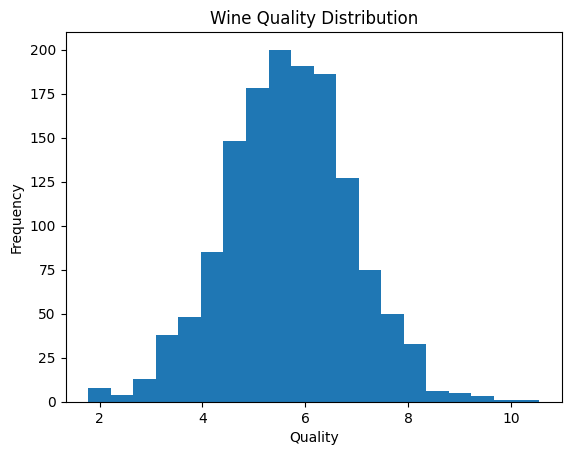

In [5]:
df[y_col].plot(kind="hist", bins=20, title="Wine Quality Distribution", xlabel="Quality")

In [6]:
df

,id,alcohol,chlorides,citric acid,density,feat01,feat02,feat03,feat04,feat05,feat06,feat07,feat08,feat09,feat10,fixed acidity,free sulfur dioxide,pH,quality,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,1,9.6,0.081,0.44,0.98920,0.777174,0.101811,0.615949,0.335220,0.072921,0.550654,0.321462,0.742844,0.120581,0.762964,9.7,23.0,3.49,4.248582,2.2,4.63,67.0,0.600
1,2,11.9,0.074,0.01,1.00371,0.682378,0.702689,0.595187,0.738317,0.079608,0.360016,0.668480,0.158404,0.377644,0.704609,7.9,33.0,3.44,6.365523,2.0,4.57,41.0,0.725
2,3,9.6,0.084,0.49,1.00870,0.477076,0.491814,0.123014,0.491648,0.112396,0.113222,0.413835,0.388120,0.513607,0.334223,9.2,23.0,3.38,5.094680,2.5,4.57,75.0,0.470
3,4,11.0,0.081,0.33,1.00490,0.745925,0.741657,0.769887,0.298042,0.167762,0.503632,0.839153,0.101733,0.157231,0.746054,7.1,24.0,3.44,5.903533,2.1,4.75,36.0,0.410
4,5,9.4,0.080,0.24,0.99620,0.729406,0.606721,0.425811,0.276605,0.944117,0.583265,0.542587,0.015201,0.796945,0.733268,7.8,6.0,3.31,6.267095,1.7,4.59,12.0,0.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1396,10.4,0.082,0.35,0.99798,0.192436,0.723544,0.199929,0.430688,0.967864,0.333939,0.500769,0.650995,0.409950,0.017794,10.7,26.0,3.24,6.535230,3.2,4.69,69.0,0.420
1396,1397,9.4,0.095,0.44,0.99708,0.704294,0.039272,0.161863,0.314071,0.774961,0.370215,0.480095,0.372677,0.517385,0.452004,9.5,11.0,3.31,4.568697,1.8,4.55,23.0,0.430
1397,1398,10.1,0.094,0.19,1.00787,0.882430,0.440148,0.837819,0.569797,0.357397,0.964399,0.281663,0.283731,0.553142,0.463633,9.0,32.0,3.25,7.242271,3.9,4.50,71.0,0.600
1398,1399,9.3,0.062,0.15,1.00550,0.545192,0.776621,0.897308,0.493320,0.982628,0.743984,0.453231,0.145450,0.573566,0.566089,6.3,8.0,3.45,5.288451,1.7,4.57,21.0,0.380


In [7]:
df.dtypes

id                        int64
alcohol                 float64
chlorides               float64
citric acid             float64
density                 float64
feat01                  float64
feat02                  float64
feat03                  float64
feat04                  float64
feat05                  float64
feat06                  float64
feat07                  float64
feat08                  float64
feat09                  float64
feat10                  float64
fixed acidity           float64
free sulfur dioxide     float64
pH                      float64
quality                 float64
residual sugar          float64
sulphates               float64
total sulfur dioxide    float64
volatile acidity        float64
dtype: object

In [8]:
df.isna().sum()

id                      0
alcohol                 0
chlorides               0
citric acid             0
density                 0
feat01                  0
feat02                  0
feat03                  0
feat04                  0
feat05                  0
feat06                  0
feat07                  0
feat08                  0
feat09                  0
feat10                  0
fixed acidity           0
free sulfur dioxide     0
pH                      0
quality                 0
residual sugar          0
sulphates               0
total sulfur dioxide    0
volatile acidity        0
dtype: int64

In [9]:
x, x_out_of_sample, y, y_out_of_sample = train_test_split(
    df[x_cols], df[y_col], test_size=0.2, random_state=42
)

In [10]:
@dataclass
class HyperoptInput:
    model: BaseEstimator
    hyperopt_space: dict[str, any] = field(default_factory=dict)


def get_pipeline_for_model(
    model: BaseEstimator, model_params: dict[str, any] | None = None
):
    return Pipeline(
        [
            ("scaler", RobustScaler()),
            (
                "feature_selection",
                SelectFromModel(XGBRegressor(), threshold="0.5*median"),
            ),
            ("model", model(**model_params if model_params else {})),
        ]
    )

In [11]:
base_hyperopt_inputs = [
    HyperoptInput(
        model=RandomForestRegressor,
        hyperopt_space={
            "model__n_jobs": [-1],
            "model__n_estimators": randint(100, 500),
            "model__max_depth": randint(3, 10),
            "model__min_samples_split": uniform(0.01, 0.1),
            "model__min_samples_leaf": uniform(0.01, 0.1),
        },
    ),
    HyperoptInput(
        model=XGBRegressor,
        hyperopt_space={
            "model__n_jobs": [-1],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 10),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__subsample": uniform(0.5, 0.5),
            "model__colsample_bytree": uniform(0.5, 0.5),
            "model__gamma": uniform(0, 5),
        },
    ),
    HyperoptInput(
        model=Ridge, hyperopt_space={"model__alpha": uniform(0.1, 100)}
    ),
    HyperoptInput(
        model=Lasso, hyperopt_space={"model__alpha": uniform(0.0001, 1.0)}
    ),
    HyperoptInput(
        model=SVR,
        hyperopt_space={
            "model__C": uniform(0.1, 10),
            "model__gamma": ["scale", "auto"],
            "model__epsilon": uniform(0.01, 0.1),
        },
    ),
    HyperoptInput(
        model=KNeighborsRegressor,
        hyperopt_space={
            "model__n_neighbors": randint(3, 30),
            "model__weights": ["uniform", "distance"],
            "model__p": [
                1,
                2,
            ],  # 1 is Manhattan distance, 2 is Euclidean distance
        },
    ),
]

In [12]:
@dataclass
class OneModelHyperoptResult:
    best_model: BaseEstimator
    best_score: float
    cv_results: pd.DataFrame

    def get_model_name(self) -> str:
        return self.best_model["model"].__class__.__name__


@dataclass
class HyperoptResults:
    results: list[OneModelHyperoptResult]

    def __post_init__(self):
        self._sort_by_best_score()

    def _sort_by_best_score(self, reversed: bool = True):
        self.results.sort(key=lambda x: x.best_score, reverse=reversed)

    def get_best_model(self):
        return self.results[0].best_model

    def get_n_best_models(self, n: int):
        return [result.best_model for result in self.results[:n]]
    
    def get_best_score(self):
        return self.results[0].best_score

    def get_merged_df(self):
        results = pd.DataFrame()
        for result in self.results:
            results = pd.concat(
                [
                    results,
                    result.cv_results.assign(
                        model_name=result.get_model_name()
                    ),
                ],
                axis=0,
            )

        return results

    def get_all_dfs(self):
        return [
            (result.get_model_name(), result.cv_results)
            for result in self.results
        ]

    def get_all_scores(self):
        return [
            (result.get_model_name(), result.best_score)
            for result in self.results
        ]

    def get_all_models(self):
        return [
            (result.get_model_name(), result.best_model)
            for result in self.results
        ]


def run_hyperopt_one_model(
    x: pd.DataFrame,
    y: pd.Series,
    model_input: HyperoptInput,
    n_iter: int = 10,
    cv: int = 5,
    random_state: int = 42,
):
    pipeline = get_pipeline_for_model(model_input.model)
    search = RandomizedSearchCV(
        pipeline,
        model_input.hyperopt_space,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        cv=cv,
        random_state=random_state,
    )
    search.fit(x, y)
    return OneModelHyperoptResult(
        best_model=search.best_estimator_,
        best_score=search.best_score_,
        cv_results=pd.DataFrame(search.cv_results_),
    )

In [13]:
def run_hyperopt(
    hyperopt_inputs=base_hyperopt_inputs,
    n_iter: int = 10,
    cv: int = 5,
    random_state: int = 42,
) -> HyperoptResults:
    results = []
    for model_input in hyperopt_inputs:
        logger.info(f"Running hyperopt for {model_input.model.__name__}")
        result = run_hyperopt_one_model(
            x=x,
            y=y,
            model_input=model_input,
            n_iter=n_iter,
            cv=cv,
            random_state=random_state,
        )
        results.append(result)
        logger.info(f"Best score: {result.best_score}")
    return HyperoptResults(results=results)

In [14]:
results = run_hyperopt()

2024-01-21 23:06:01.804 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for RandomForestRegressor


2024-01-21 23:06:14.148 | INFO     | __main__:run_hyperopt:19 - Best score: -1.063872334462141
2024-01-21 23:06:14.149 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for XGBRegressor
2024-01-21 23:06:18.707 | INFO     | __main__:run_hyperopt:19 - Best score: -1.044570102807818
2024-01-21 23:06:18.707 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for Ridge
2024-01-21 23:06:20.839 | INFO     | __main__:run_hyperopt:19 - Best score: -1.0554349671339018
2024-01-21 23:06:20.885 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for Lasso
2024-01-21 23:06:23.193 | INFO     | __main__:run_hyperopt:19 - Best score: -1.0692471470244878
2024-01-21 23:06:23.194 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for SVR
2024-01-21 23:06:25.792 | INFO     | __main__:run_hyperopt:19 - Best score: -1.0674628872883367
2024-01-21 23:06:25.793 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for KNeighborsRegressor
2024-01-21 23:06:27.936 | INFO     | __main__:run_hyp

In [15]:
results.get_all_scores()

[('XGBRegressor', -1.044570102807818),
 ('Ridge', -1.0554349671339018),
 ('RandomForestRegressor', -1.063872334462141),
 ('SVR', -1.0674628872883367),
 ('Lasso', -1.0692471470244878),
 ('KNeighborsRegressor', -1.1072753707966632)]

In [16]:
best_model = results.get_best_model()
best_model

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        grow_policy=None,
                                                        importanc...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.013979488347959958, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=365, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...))])

In [17]:
best_models = results.get_n_best_models(5)

In [18]:
@dataclass
class RegressionScores:
    model_name: str
    mean_squared_error: float
    mean_absolute_error: float
    root_mean_squared_error: float

def calculate_regression_scores(
    model: BaseEstimator, X_test: pd.DataFrame, y_test: pd.Series
) -> RegressionScores:
    y_pred = model.predict(X_test)
    y_pred = [
        max(0, min(pred, 10)) for pred in y_pred
    ]  # ensure that we don't have negative or >10 predictions
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mse)

    return RegressionScores(
        model_name=model["model"].__class__.__name__,
        mean_squared_error=mse,
        mean_absolute_error=mae,
        root_mean_squared_error=rmse,
    )

In [19]:
best_model_scores = calculate_regression_scores(
    best_model, x_out_of_sample, y_out_of_sample
)
best_model_scores

RegressionScores(model_name='XGBRegressor', mean_squared_error=1.36515466797506, mean_absolute_error=0.8952051777187162, root_mean_squared_error=1.1683983344626352)

In [20]:
best_models_scores = [
    calculate_regression_scores(model, x_out_of_sample, y_out_of_sample)
    for model in best_models
]
best_models_scores
best_models_scores_df = pd.DataFrame(
    best_models_scores, index=[model.__class__.__name__ for model in best_models]
).sort_values("root_mean_squared_error").round(3)
best_models_scores_df

,model_name,mean_squared_error,mean_absolute_error,root_mean_squared_error
Pipeline,RandomForestRegressor,1.340,0.880,1.157
Pipeline,XGBRegressor,1.365,0.895,1.168
Pipeline,SVR,1.383,0.910,1.176
Pipeline,Lasso,1.404,0.915,1.185
Pipeline,Ridge,1.415,0.914,1.190


In [21]:
best_models_scores_train = [
    calculate_regression_scores(model, x, y)
    for model in best_models
]
best_models_scores_train
best_models_scores_df_trian = pd.DataFrame(
    best_models_scores_train, index=[model.__class__.__name__ for model in best_models]
).sort_values("root_mean_squared_error").round(3)
best_models_scores_df_trian

,model_name,mean_squared_error,mean_absolute_error,root_mean_squared_error
Pipeline,RandomForestRegressor,0.707,0.669,0.841
Pipeline,XGBRegressor,0.753,0.702,0.868
Pipeline,SVR,1.000,0.777,1.000
Pipeline,Ridge,1.079,0.830,1.039
Pipeline,Lasso,1.121,0.845,1.059


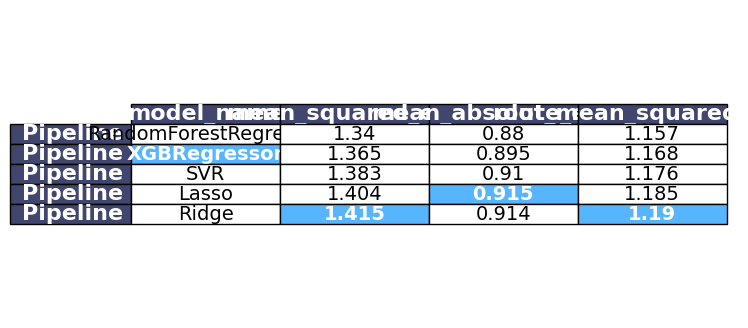

In [22]:
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(8, 4)) # size a bit smaller than the image for better fit

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Table properties
tbl = table(ax, best_models_scores_df, loc='center', cellLoc='center', colWidths=[0.2]*len(best_models_scores_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.2, 1.2)

# Changing the column headers style
for (i, (key, cell)) in enumerate(tbl.get_celld().items()):
    if key[0] == 0 or key[1] < 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')

# Highlighting the maximum values in each column
for i, column in enumerate(best_models_scores_df.columns):
    max_val = best_models_scores_df[column].max()
    for j, value in enumerate(best_models_scores_df[column]):
        if value == max_val:
            cell = tbl.get_celld()[(j+1, i)]
            cell.set_facecolor('#56b5fd')
            cell.set_text_props(weight='bold', color='white')

plt.show()

In [23]:
results.get_merged_df()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__n_jobs,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model_name,param_model__alpha,param_model__min_samples_leaf,param_model__min_samples_split,param_model__C,param_model__epsilon,param_model__n_neighbors,param_model__p,param_model__weights
0,0.235349,0.026645,0.002859,0.002345,0.68727,4.753572,0.229598,7,70,-1,0.578009,{'model__colsample_bytree': 0.6872700594236812...,-1.167810,-1.131749,-1.088761,-1.075842,-1.159164,-1.124665,0.036809,9,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.320096,0.032632,0.002603,0.000979,0.577997,0.290418,0.269853,6,409,-1,0.854036,{'model__colsample_bytree': 0.5779972601681014...,-1.191152,-1.101002,-1.151351,-1.112768,-1.201978,-1.151650,0.040424,10,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.321968,0.011695,0.001932,0.000393,0.510292,4.849549,0.259733,8,435,-1,0.590912,{'model__colsample_bytree': 0.5102922471479012...,-1.104905,-1.103584,-1.076270,-1.106367,-1.207748,-1.119775,0.045376,8,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.288585,0.029518,0.001972,0.000191,0.591702,1.521211,0.167427,6,394,-1,0.645615,{'model__colsample_bytree': 0.5917022549267169...,-1.163602,-1.095527,-1.053442,-1.094114,-1.165794,-1.114496,0.043694,7,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.398880,0.022359,0.002979,0.001573,0.805926,0.697469,0.097643,9,239,-1,0.545303,{'model__colsample_bytree': 0.8059264473611898...,-1.117959,-1.060828,-1.044260,-1.028875,-1.157861,-1.081957,0.048461,4,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.247234,0.009829,0.002373,0.001430,0.809193,1.91231,0.304969,3,180,-1,0.92997,{'model__colsample_bytree': 0.8091930046665436...,-1.087326,-1.065396,-1.102594,-1.053806,-1.211429,-1.104110,0.056268,6,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.360129,0.025295,0.001988,0.000023,0.840154,2.252496,0.013979,3,365,-1,0.781644,{'model__colsample_bytree': 0.8401537692938899...,-1.061231,-1.036653,-1.007458,-1.009193,-1.108315,-1.044570,0.037503,1,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.491650,0.080416,0.002119,0.000056,0.692708,0.079831,0.079268,6,416,-1,0.841632,"{'model__colsample_bytree': 0.692708251269958,...",-1.128034,-1.078495,-1.065067,-1.055379,-1.166236,-1.098642,0.042042,5,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.290419,0.014380,0.001853,0.000039,0.804998,4.165975,0.062009,3,469,-1,0.591118,{'model__colsample_bytree': 0.8049983288913105...,-1.098308,-1.036571,-1.018584,-1.005914,-1.114813,-1.054838,0.043654,2,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.309330,0.029154,0.002024,0.000063,0.877681,2.125779,0.072382,6,359,-1,0.515657,{'model__colsample_bytree': 0.8776807051588262...,-1.117044,-1.068844,-1.034952,-1.048080,-1.137696,-1.081323,0.039661,3,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


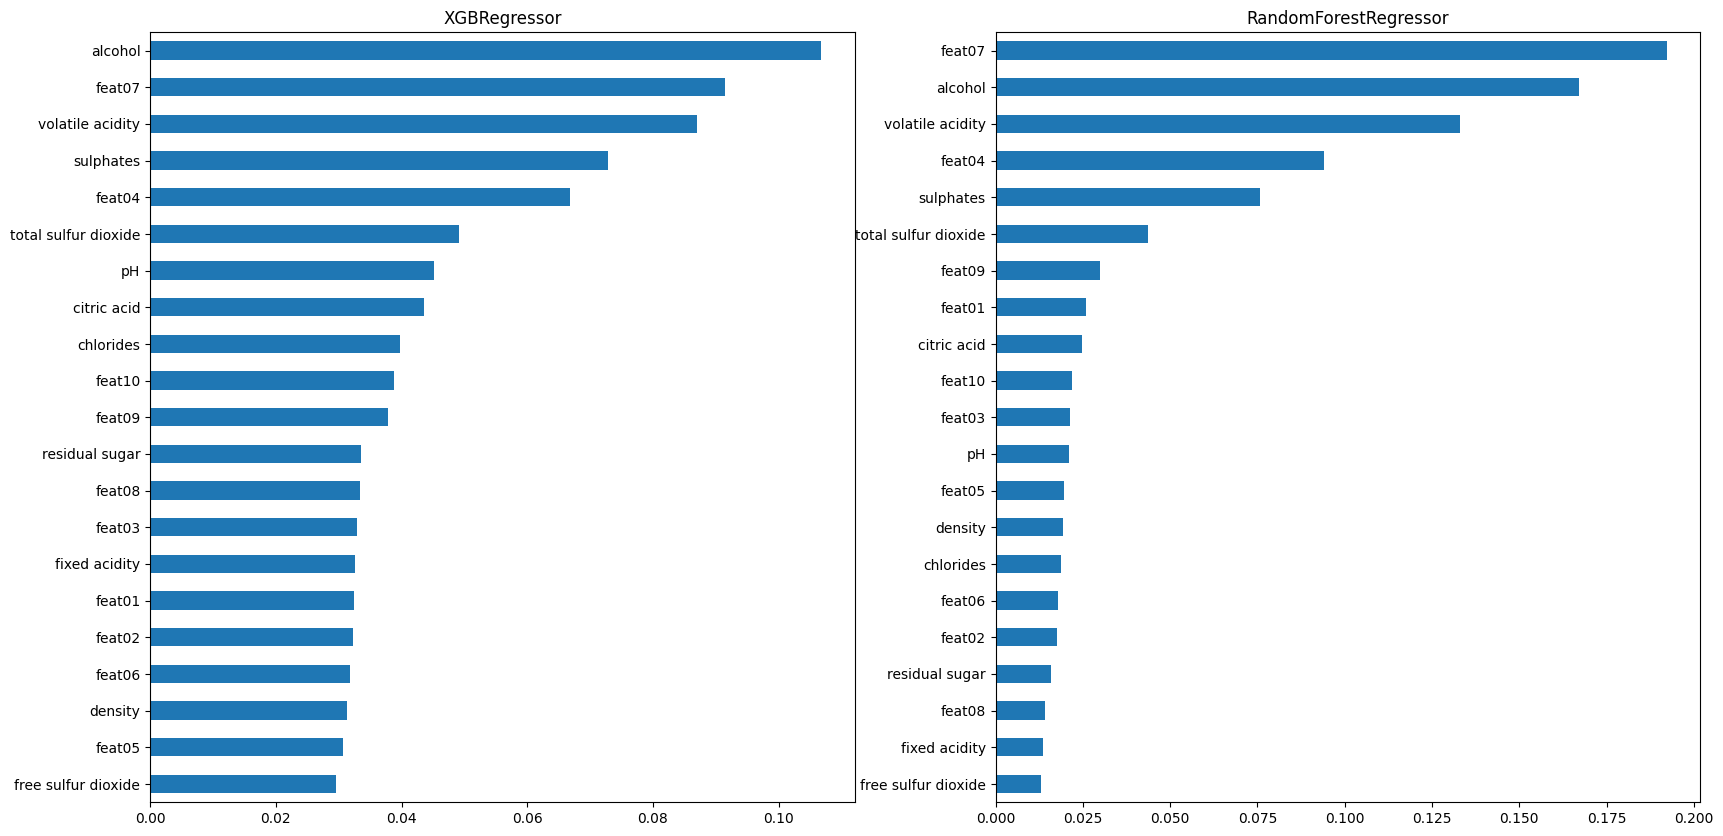

In [28]:
plt.subplots(1, 2, figsize=(20, 10))  # Changed from (2, 2) to (1, 2)
i = 0
model_count = 0
while model_count < 2 and i < len(results.results):
    model = results.results[i].best_model['model']
    if hasattr(model, 'feature_importances_'):
        plt.subplot(1, 2, model_count+1)  # Changed from (2, 2, model_count+1) to (1, 2, model_count+1)
        pd.Series(model.feature_importances_, index=x.columns).groupby(lambda x: x.split('_')[0]).mean().sort_values(ascending=True).plot(kind='barh')
        plt.title(results.results[i].get_model_name())
        model_count += 1
    i += 1

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Feature'>

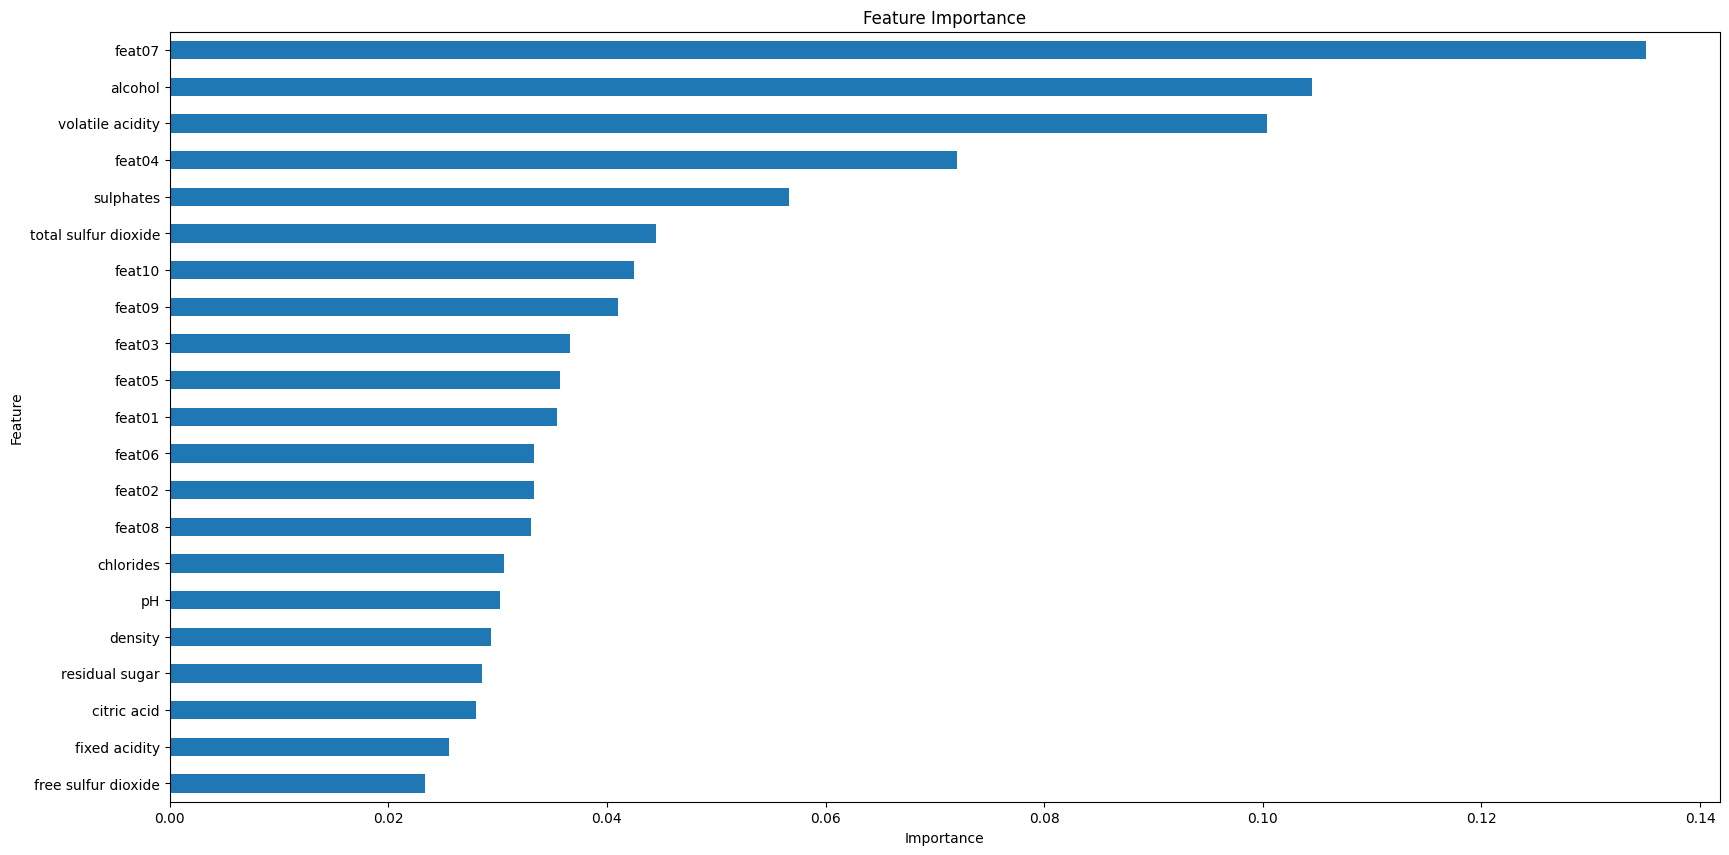

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x, y)
plt.rcParams["figure.figsize"] = [20, 10]
pd.Series(rf.feature_importances_, index=x.columns).groupby(
    lambda x: x.split("_")[0]
).mean().sort_values(ascending=True).plot(
    kind="barh",
    title="Feature Importance",
    xlabel="Importance",
    ylabel="Feature",
)

In [ ]:
import h2o
h2o.init()
train = h2o.H2OFrame(pd.concat([x, y], axis=1))
test = h2o.H2OFrame(pd.concat([x_out_of_sample, y_out_of_sample], axis=1))

In [27]:
def oos_predict_with_h2o(model_id, test_frame):
    return mean_absolute_error(test_frame.as_data_frame()['quality'],h2o.get_model(model_id).predict(test_frame).as_data_frame())

In [ ]:
aml_atp = h2o.automl.H2OAutoML(max_runtime_secs=600, stopping_metric='aucpr', nfolds=5, sort_metric='aucpr')
aml_atp.train(x=[col for col in train.columns if col != 'class'], y='class', training_frame=train)
lb = aml_atp.leaderboard

In [24]:
leaderboard = lb.as_data_frame()
leaderboard['oos_mae'] = leaderboard['model_id'].apply(lambda x: oos_predict_with_h2o(x, test))
leaderboard.sort_values(by='oos_mae', ascending=False)

/home/ubuntu/.local/lib/python3.10/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


NameError: name 'average_precision_score' is not defined

In [10]:
lb

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_3_AutoML_1_20240124_222507,0.840925,1.05002,1.10254,0.167243,1.10254
StackedEnsemble_Best1000_1_AutoML_1_20240124_222507,0.841176,1.05467,1.11233,0.168397,1.11233
StackedEnsemble_BestOfFamily_5_AutoML_1_20240124_222507,0.841401,1.05244,1.10763,0.167417,1.10763
StackedEnsemble_BestOfFamily_7_AutoML_1_20240124_222507,0.841442,1.05038,1.1033,0.167302,1.1033
StackedEnsemble_BestOfFamily_4_AutoML_1_20240124_222507,0.841867,1.05347,1.1098,0.167526,1.1098
StackedEnsemble_AllModels_2_AutoML_1_20240124_222507,0.842305,1.05083,1.10424,0.16744,1.10424
StackedEnsemble_AllModels_4_AutoML_1_20240124_222507,0.842395,1.05439,1.11174,0.168479,1.11174
StackedEnsemble_BestOfFamily_8_AutoML_1_20240124_222507,0.843403,1.05044,1.10343,0.167122,1.10343
StackedEnsemble_AllModels_1_AutoML_1_20240124_222507,0.843678,1.05349,1.10983,0.167851,1.10983
StackedEnsemble_AllModels_3_AutoML_1_20240124_222507,0.844063,1.05356,1.10999,0.167936,1.10999
